In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rt82dznn
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-rt82dznn
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1694556533.224118390420868118806081040175592332373432988400-py3-none-any.whl size=301567 sha256=bdbab5f1107425702e478a9e5da63ae1b91e69a4256911b6018e01ca77555de3
  Stored in directory: /tmp/pip-ephem-wheel-cache-vefcll57/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [2]:
import tensorflow as tf

In [3]:
#import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
os.environ["KAGGLE_USERNAME"] = "pallikadhingra"
os.environ["KAGGLE_KEY"] = "2155eaeb2bc1983bdcb70ae4d0c55faa"

!kaggle datasets download balraj98/monet2photo

 95% 277M/291M [00:02<00:00, 130MB/s]
100% 291M/291M [00:02<00:00, 116MB/s]


In [5]:
!unzip /content/monet2photo.zip

Streaming output truncated to the last 5000 lines.
  inflating: trainB/2015-02-12 11_31_32.jpg  
  inflating: trainB/2015-02-12 12_30_32.jpg  
  inflating: trainB/2015-02-12 19_51_27.jpg  
  inflating: trainB/2015-02-12 20_53_44.jpg  
  inflating: trainB/2015-02-12 21_31_48.jpg  
  inflating: trainB/2015-02-13 09_22_26.jpg  
  inflating: trainB/2015-02-13 10_07_16.jpg  
  inflating: trainB/2015-02-13 13_57_11.jpg  
  inflating: trainB/2015-02-13 16_02_50.jpg  
  inflating: trainB/2015-02-13 16_45_49.jpg  
  inflating: trainB/2015-02-14 00_09_27.jpg  
  inflating: trainB/2015-02-14 02_21_28.jpg  
  inflating: trainB/2015-02-14 02_26_30.jpg  
  inflating: trainB/2015-02-14 10_38_14.jpg  
  inflating: trainB/2015-02-14 12_37_48.jpg  
  inflating: trainB/2015-02-14 17_22_56.jpg  
  inflating: trainB/2015-02-14 23_02_26.jpg  
  inflating: trainB/2015-02-15 00_28_30.jpg  
  inflating: trainB/2015-02-15 01_54_05.jpg  
  inflating: trainB/2015-02-15 02_39_15.jpg  
  inflating: trainB/2015-02-1

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

In [7]:
train_monet = "/content/trainA"
train_photos = "/content/trainB"
images_height = 256
images_width = 256
#total_images = 4000

In [8]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[images_height, images_width, 3])

  return cropped_image

In [9]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
images_monet = os.listdir(train_monet)
images_photos = os.listdir(train_photos)

In [11]:
n_monet = len(images_monet)
n_photos = len(images_photos)

In [12]:
n_monet = 40
n_photos = 10
batch_size = 1

In [15]:
images_monet_list = []
images_photos_list = []

for i in tqdm(range(n_monet)):
  img = cv2.imread(train_monet + "/" + images_monet[i])
  img = cv2.resize(img, (images_width, images_height))
  img=img/255.0 #normalisation
  images_monet_list.append(img)

for i in tqdm(range(n_photos)):
  img = cv2.imread(train_photos + "/" + images_photos[i])
  img = cv2.resize(img, (images_width, images_height))
  img=img/255.0 #normalisation
  images_photos_list.append(img)

images_monet_arr = np.array(images_monet_list)
images_photos_arr = np.array(images_photos_list)


100%|██████████| 10/10 [00:00<00:00, 303.60it/s]


In [16]:
sample = np.expand_dims(images_monet_arr[0],axis=0)

In [17]:
sample.shape

(1, 256, 256, 3)

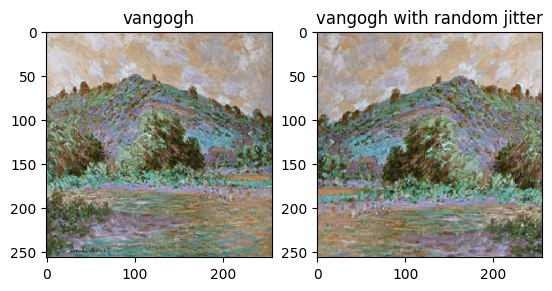

In [18]:
plt.subplot(121)
plt.title('vangogh')
plt.imshow(images_monet_arr[0])

plt.subplot(122)
plt.title('vangogh with random jitter')
plt.imshow(random_jitter(images_monet_arr[0]))

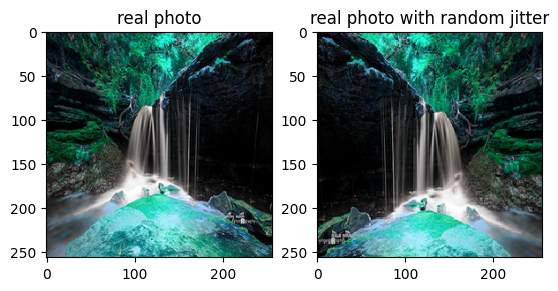

In [19]:
plt.subplot(121)
plt.title('real photo')
plt.imshow(images_photos_arr[0])

plt.subplot(122)
plt.title('real photo with random jitter')
plt.imshow(random_jitter(images_photos_arr[0]))

In [20]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [29]:
sample_photo = np.expand_dims(images_photos_arr[7],axis=0)
sample_monet = np.expand_dims(images_monet_arr[3],axis=0)

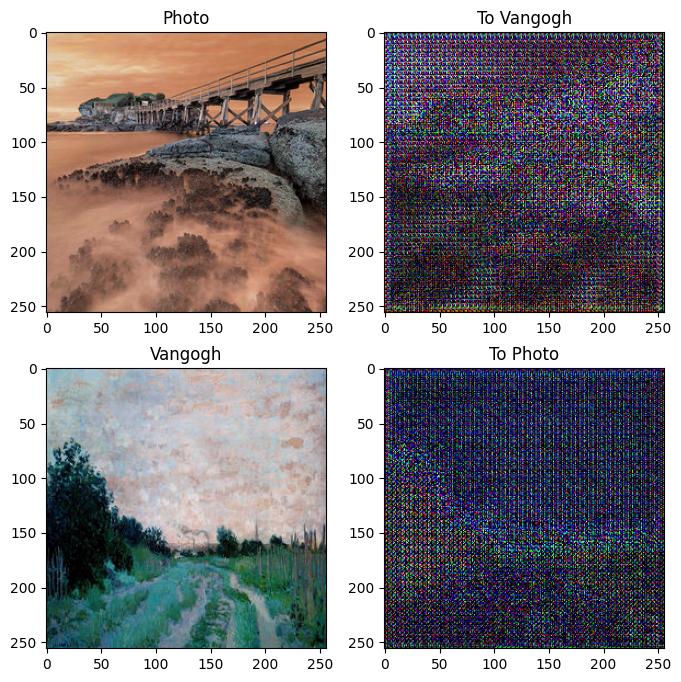

In [30]:
to_vangogh = generator_g(sample_photo)
to_photo = generator_f(sample_monet)
plt.figure(figsize=(8, 8))
contrast = 3

imgs = [sample_photo, to_vangogh, sample_monet, to_photo]
title = ['Photo', 'To Vangogh', 'Vangogh', 'To Photo']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0])
  else:
    plt.imshow(imgs[i][0]*contrast)
plt.show()

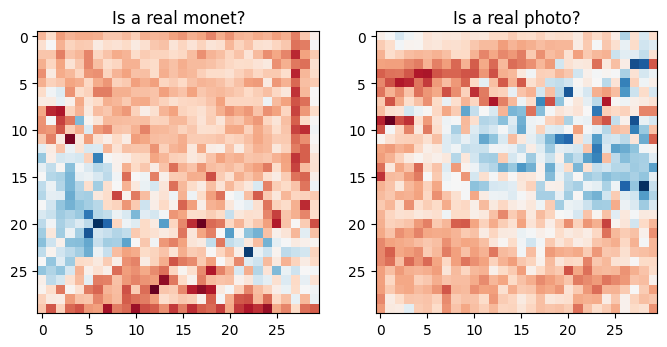

In [32]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real monet?')
plt.imshow(discriminator_y(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_x(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [33]:
LAMBDA = 10

In [34]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [36]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [37]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [38]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * loss

In [39]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [41]:
EPOCHS = 10

In [42]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [43]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

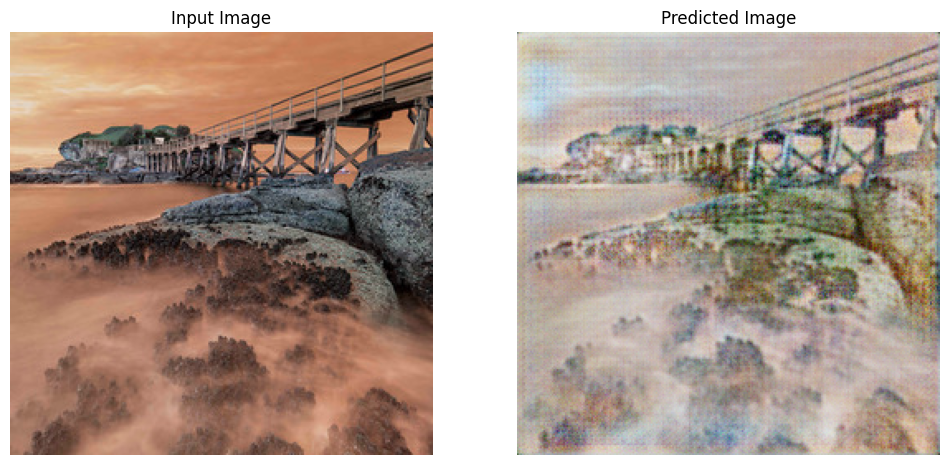

Saving checkpoint for epoch 300 at ./checkpoints/train/ckpt-60
Time taken for epoch 300 is 13.051815748214722 sec



In [44]:
for epoch in range(300):
  start = time.time()

  n = 0
  for image_x, image_y in zip(np.expand_dims(images_photos_arr, axis = 0).astype(np.float32), np.expand_dims(images_monet_arr, axis = 0).astype(np.float32)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [47]:
test_images = "/content/testB"

In [48]:
test_images_photos = os.listdir(test_images)

In [49]:
n_images_test = 20

In [50]:
test_images_photos_list = []

for i in tqdm(range(n_images_test)):
  img = cv2.imread(test_images + "/" + test_images_photos[i])
  img = cv2.resize(img, (images_width, images_height))
  img=img/255.0 #normalisation
  test_images_photos_list.append(img)

test_images_photos_arr = np.array(test_images_photos_list)


100%|██████████| 20/20 [00:00<00:00, 132.16it/s]


In [71]:
inp = np.expand_dims(test_images_photos_arr[13],axis=0)

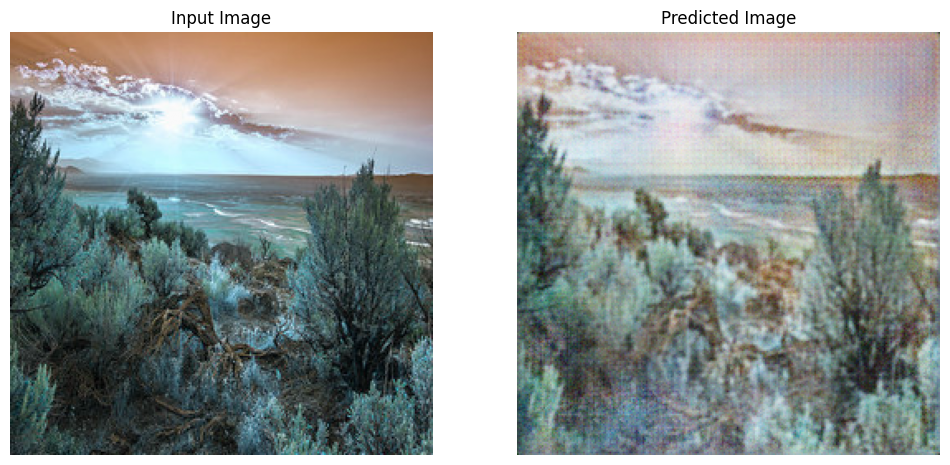

In [72]:
# Run the trained model on the test dataset

generate_images(generator_g, inp)